In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from util_data import *
from baseline_smc import *
from util_plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import datetime
import time 
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

('probtorch:', '0.0+5a2c637', 'torch:', '1.0.0.dev20181029', 'cuda:', True)


In [9]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 30
T_max = 50
K = 4
D = 2
dt = 10
Boundary = 30
noise_ratio = 1

## Model Parameters
num_particles = 50
num_particles_smc = 50
NUM_HIDDEN = 128
NUM_LATENTS = K*K
NUM_OBS = 2 * K

NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "baseline_smc/hao/baseline_2shots-%dIS-enc-%s" % (num_particles, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

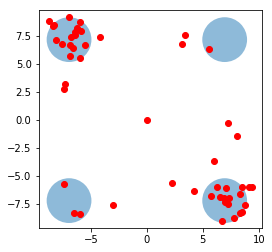

In [3]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq_T(T, K, dt, Boundary, init_v, noise_cov)
## true global variables
cov_true = np.tile(noise_cov, (K, 1, 1))
dirs = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
mu_true = np.tile(np.absolute(init_v), (K, 1)) * dirs
plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [ ]:
# for i in range(10):
#     a = log_weights[:, -1] - logsumexp(log_weights[:, -1], dim=0)
#     print(Categorical(a).sample().item())
# b = torch.FloatTensor([-3,-2,-1,-4])
# for i in range(10):
#     print(Categorical(b).sample())
#     c = torch.exp(b - logsumexp(b, dim=0))
#     print(Categorical(c).sample())
#     print('===============')

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = torch.exp(self.latent_dir(hidden)).sum(0).view(K, K)
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample()
        return latents_dirs, A_samples

In [5]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [6]:
KLs = []
EUBOs = []
ESSs = []

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    mu_ks, cov_ks, Pi, Y, A_true, Z_true = generate_seq_T(T, K, dt, Boundary, init_v, noise_cov)
    enc, eubo, kl, ess, latents_dirs = twoshots_sampling(A_true, enc, alpha_trans_0, Pi, mu_ks, cov_ks, Z_true, Y, T, D, K, num_particles, num_particles_smc)
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ESSs.append(ess / num_particles)
#     log_qs.append(loss_infer.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, KL : %f (%ds)' % (epoch, eubo, kl, time_end - time_start))

if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)

epoch : 0, eubo : -283.837097, KL : 524.648071 (4s)
epoch : 1, eubo : -305.526855, KL : 368.521576 (3s)
epoch : 2, eubo : -257.568848, KL : 377.635834 (3s)
epoch : 3, eubo : -314.236481, KL : 512.520508 (3s)
epoch : 4, eubo : -356.376984, KL : 451.411835 (3s)
epoch : 5, eubo : -363.642090, KL : 420.802917 (3s)
epoch : 6, eubo : -302.226990, KL : 414.739044 (3s)
epoch : 7, eubo : -277.216736, KL : 343.739014 (3s)
epoch : 8, eubo : -387.881775, KL : 445.079620 (3s)
epoch : 9, eubo : -239.177521, KL : 231.218597 (2s)
epoch : 10, eubo : -307.139618, KL : 396.675751 (3s)
epoch : 11, eubo : -410.658539, KL : 337.272064 (3s)
epoch : 12, eubo : -239.181686, KL : 222.905579 (2s)
epoch : 13, eubo : -375.189514, KL : 408.184418 (3s)
epoch : 14, eubo : -276.195160, KL : 272.628632 (2s)
epoch : 15, eubo : -333.415009, KL : 346.764587 (3s)
epoch : 16, eubo : -217.720444, KL : 208.999222 (2s)
epoch : 17, eubo : -250.948166, KL : 263.055267 (2s)
epoch : 18, eubo : -245.297424, KL : 237.329529 (2s)
epo

variational : 
tensor([[6.5145, 1.4785, 0.7412, 1.1759],
        [1.3627, 5.6170, 0.9712, 0.6775],
        [1.0857, 1.3740, 4.8764, 1.7040],
        [1.4843, 1.0167, 1.4418, 5.0177]], grad_fn=<ViewBackward>)
conjugate posterior :
tensor([[12.,  3.,  1.,  1.],
        [ 3., 13.,  2.,  1.],
        [ 1.,  1.,  3.,  2.],
        [ 1.,  1.,  1.,  2.]])


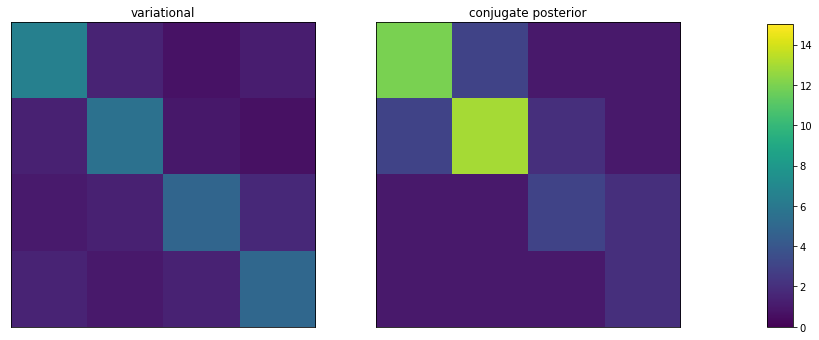

In [7]:
plot_dirs(latents_dirs, alpha_trans_0, Z_true, T, K, vmax=15)

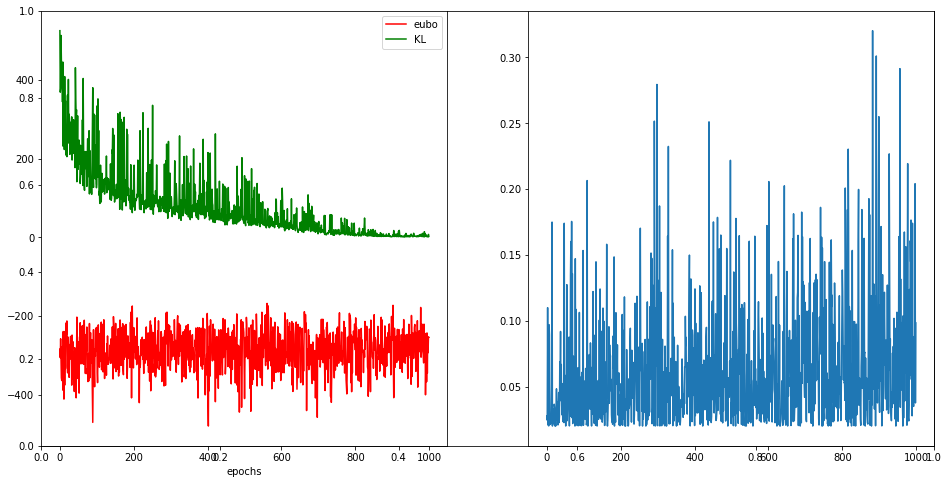

In [11]:
plot_results(EUBOs, KLs, ESSs)

In [10]:
if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)